# Krypton Corrections

## Correct energy using Kr maps and obtain resolution

### Author: JJGC

In [3]:
%load_ext autoreload
%autoreload 2
import os
import time
import datetime 
print("Last updated on ", time.asctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Wed Aug 29 22:24:22 2018


### Input files

In [4]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_maps_xy_6206.h5'
map_file_name_ts  = 'kr_maps_xy_ts_6206.h5'
emap_file_name    = ' '

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [8]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map
from krcal.core.io_functions       import read_maps_ts

In [9]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg
from krcal.core.core_functions      import NN

In [10]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [11]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [12]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [13]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [14]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [15]:
from krcal.core.map_functions   import energy_map
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_map
from krcal.core.map_functions   import draw_maps_ts

In [16]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [17]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import lt_correction
from krcal.core.correction_functions import lt_correction_ts
from krcal.core.correction_functions import e0_correction_ts

In [18]:
import krcal.dev.corrections       as corrections 


In [19]:
from numpy import pi

In [20]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [21]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [22]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10000_19999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_20000_29999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_6206.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_ts_6206.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ')

In [23]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [24]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 4085430


In [26]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Select in R

In [306]:
RMAX       =180
NSECTORS   =20   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =10  # size of the wedge in degrees

fr = RMAX / NSECTORS
fphi = SPHI
print(f'fr = {fr}, fphi = {fphi}')



fr = 9.0, fphi = 10


In [28]:
dstf = dst[dst.R<RMAX]

In [29]:
dst = dstf

### Time differences in seconds

In [30]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [31]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Raw S2 energy vs Z

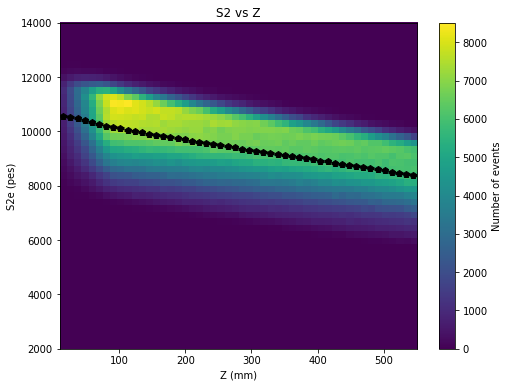

In [32]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

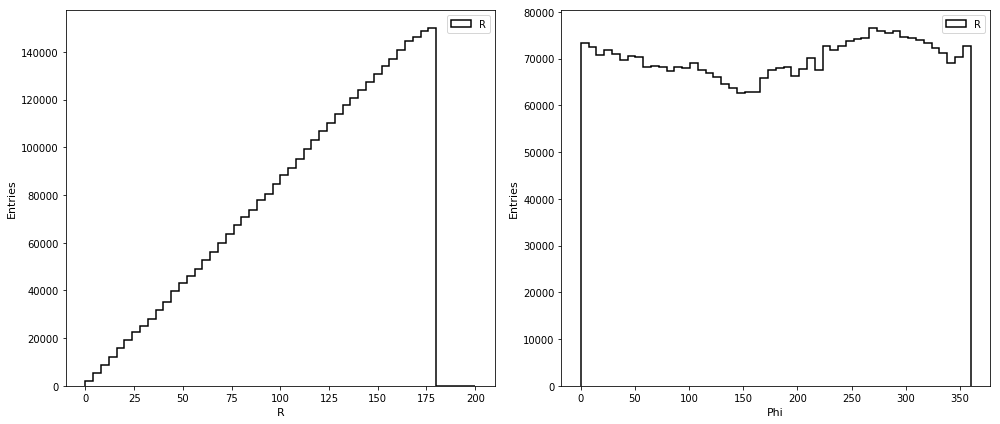

In [33]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(dst.R, bins=50, range = (0,200), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(phirad_to_deg(dst.Phi), bins=50, range = (0,360), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Load maps

In [155]:
me0df, me0udf, mltdf, mltudf = read_maps(fn.map_file_name)
mu = (me0df.mean()).mean()
mx = (me0df.max()).max()

### Load TS Maps

In [156]:
ts, tsMaps = read_maps_ts(fn.map_file_name_ts)

In [40]:
#R, PHI = rphi_sector_alpha_map(rmin  =  20,
#                               rmax  = 180,
#                               alpha =  0.5,
#                               sphi  = 5)

rmin = 20, rmax = 180, alpha =0.5, nSectors = 41


In [157]:
R, PHI = rphi_sector_map(nSectors=20, rmax=180, sphi=10)

In [158]:
W = define_rphi_sectors(R, PHI, verbose=False)
nSectors = len(R.keys())
print(f'nSectors = {nSectors}')

nSectors = 20


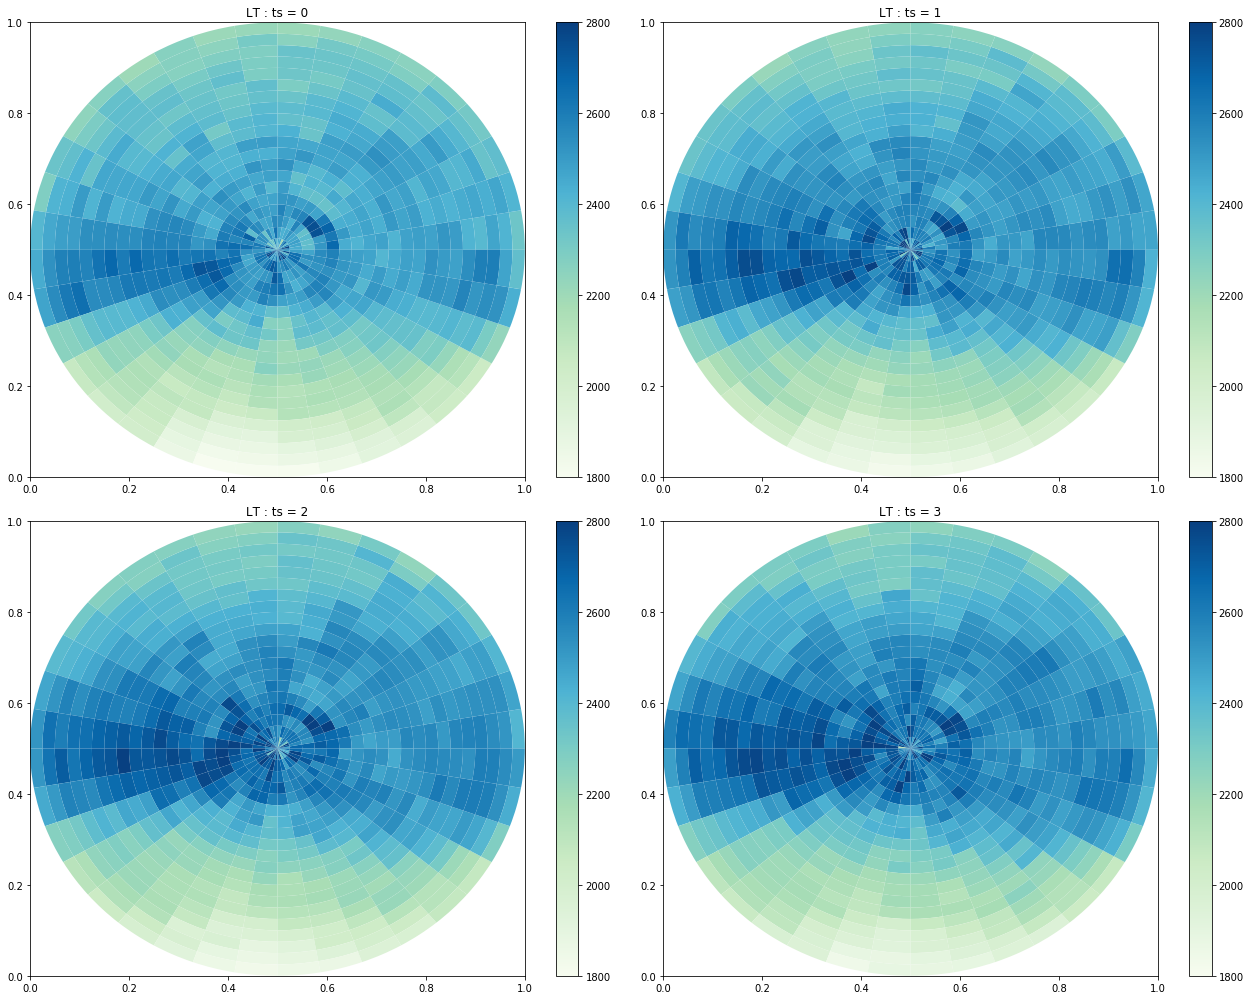

In [159]:
draw_maps_ts(W, tsMaps.values(),  
             wmap   = MapType.LT,
             ltlims = (1800, 2800),
             cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
             alpha   = 1.0,  
             figsize=(18,14))

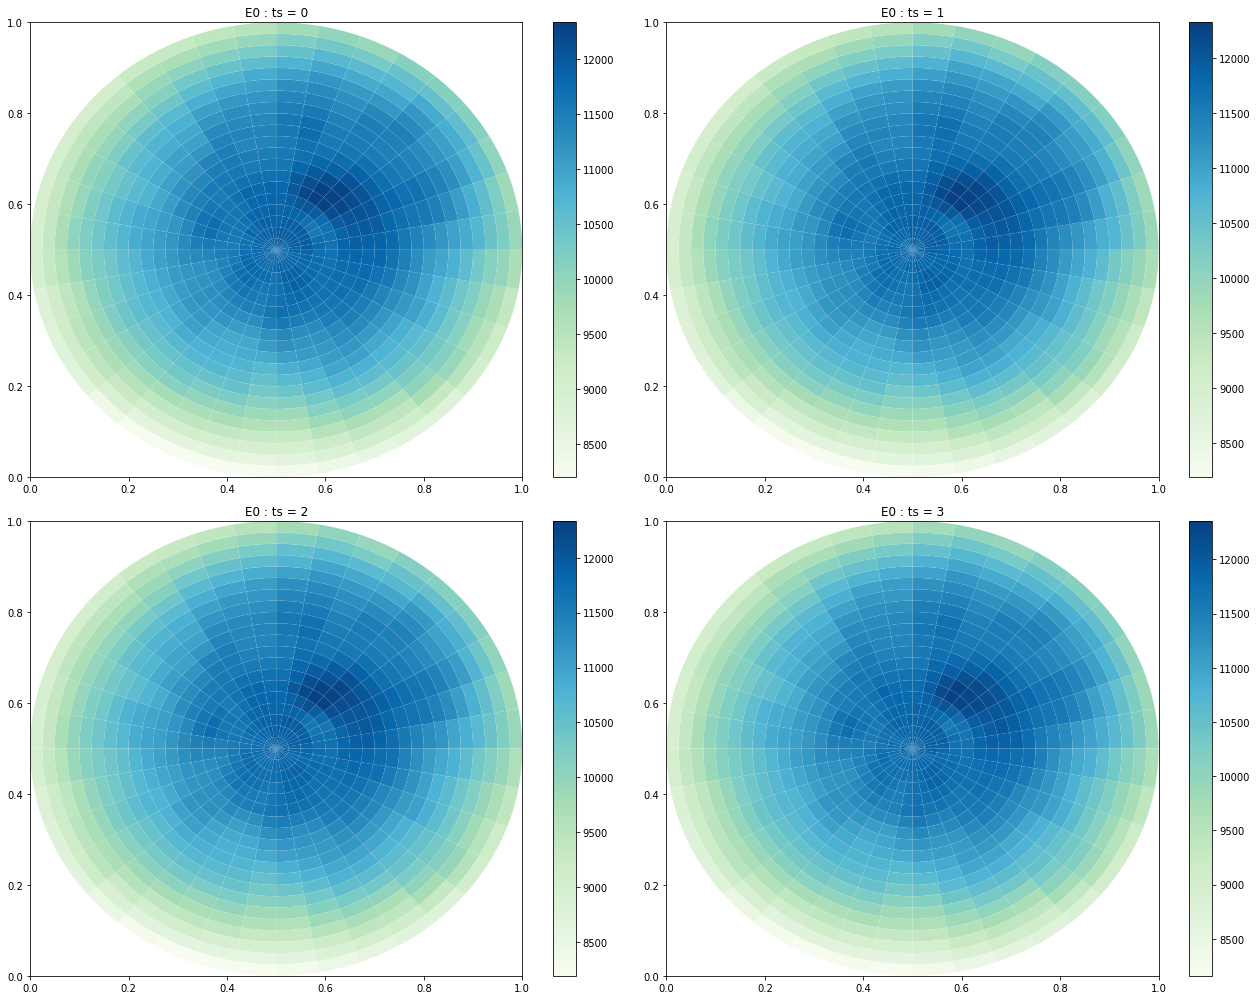

In [160]:
draw_maps_ts(W, tsMaps.values(),  
             wmap   = MapType.E0,
             cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
             alpha   = 1.0,  
             figsize=(18,14))

### E0 (geometry) correction

In [274]:
t0 = time.time()
E0 = e0_correction(dst.S2e.values, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = me0df / mu,  # normalize to max E0
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 28.254687070846558


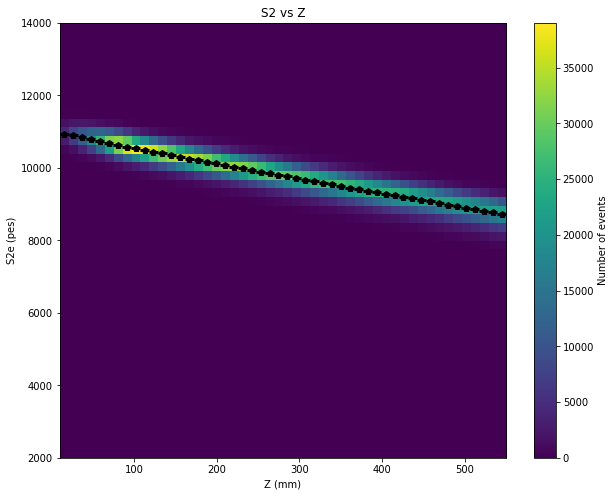

In [275]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [276]:
t0 = time.time()
E = lt_correction(E0, 
                  dst.R.values, 
                  dst.Phi.values,
                  dst.Z.values, 
                  CLT = mltdf,
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 29.649284839630127


In [277]:
kge = kr_event(dst, DT, E0, dst.S2q)

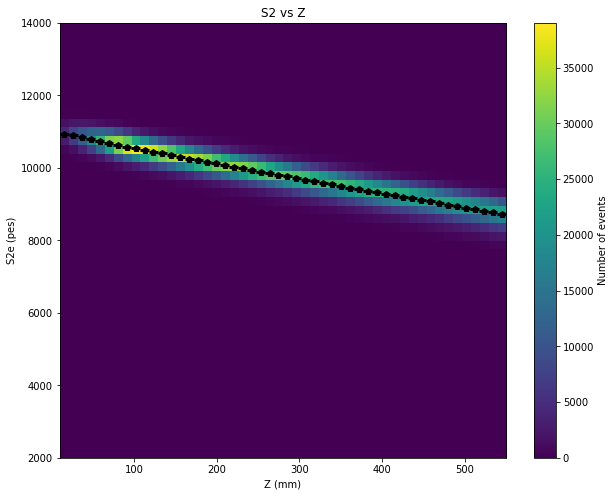

In [278]:
nevt = h2d(kge.Z, kge.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [279]:
kre = kr_event(dst, DT, E, dst.S2q)

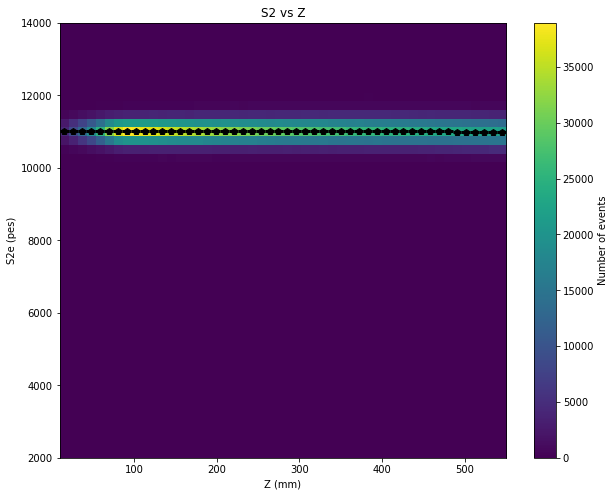

In [280]:
nevt = h2d(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

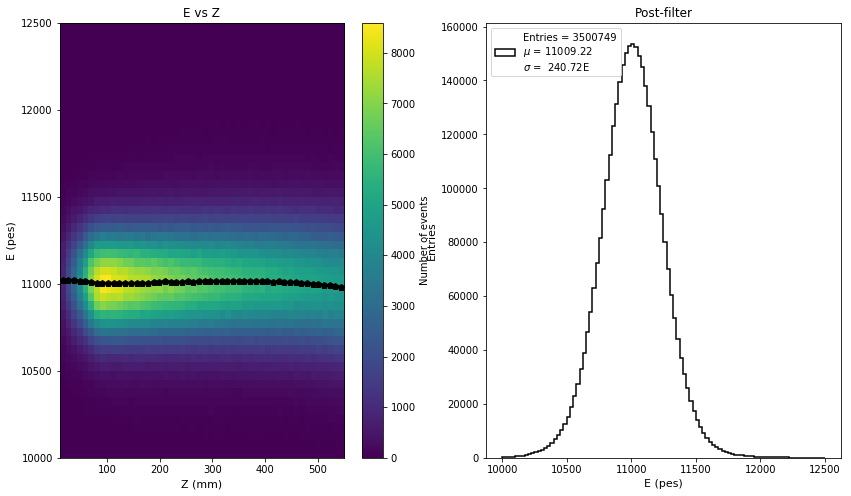

In [281]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 12500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

In [282]:
fc = fit_energy(E, nbins=100, range=(10000, 12500))

  Fit was valid = True
 Emu       = 11008.749321594461 +-0.12586662305667262 
 E sigma   = 232.15154584773705 +-0.09685765437719848 
 chi2    = 10.524878106226167 
 sigma E/E (FWHM)     (%) =4.955659510495294
 sigma E/E (FWHM) Qbb (%) =0.6400331207555917 


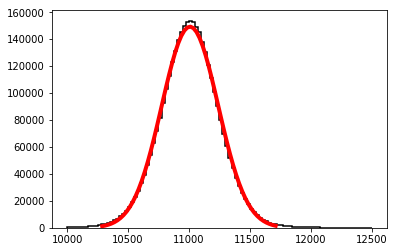

In [283]:
plot_fit_energy(fc)
print_fit_energy(fc)

### Using time dependent maps

In [171]:
kdst = kr_event(dst, DT, dst.S2e, dst.S2q)

In [307]:
t0 = time.time()
kge = e0_correction_ts(kdst, ts, tsMaps, fr, fphi)
                  
t1 = time.time()
print(f' E0 correction: t = {t1 -t0}')

time sector 0
time sector 1
time sector 2
time sector 3
 E0 correction: t = 30.02026391029358


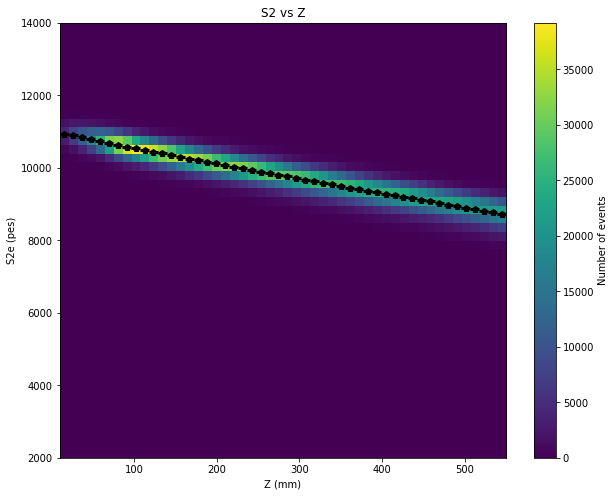

In [308]:
nevt = h2d(kge.Z, kge.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [309]:
t0 = time.time()
kre = lt_correction_ts(kge, ts, tsMaps, fr, fphi)
                  
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

(836967,)
(858833,)
(854094,)
(950853,)
 LT correction: t = 30.43673610687256


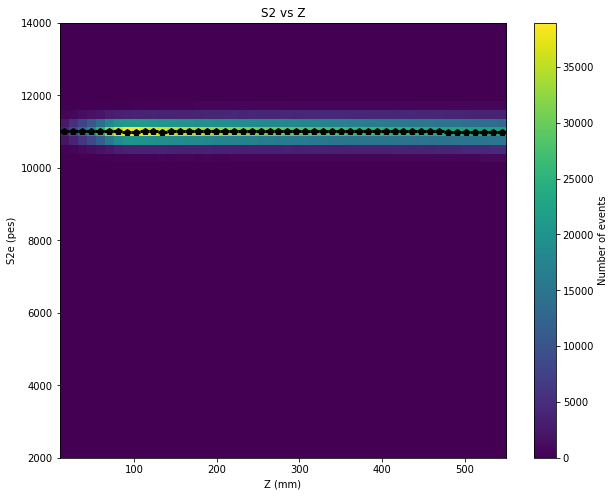

In [310]:
nevt = h2d(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

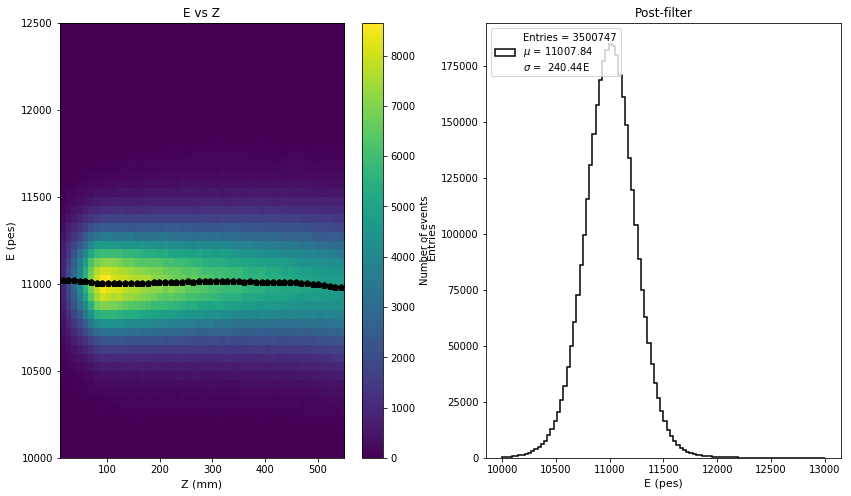

In [176]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 12500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kre.E,  bins = 100, range =(10000,13000), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

### Using time-dependent does not buy any extra resolution. Why??

### Time dependence before/after correction

#### Before

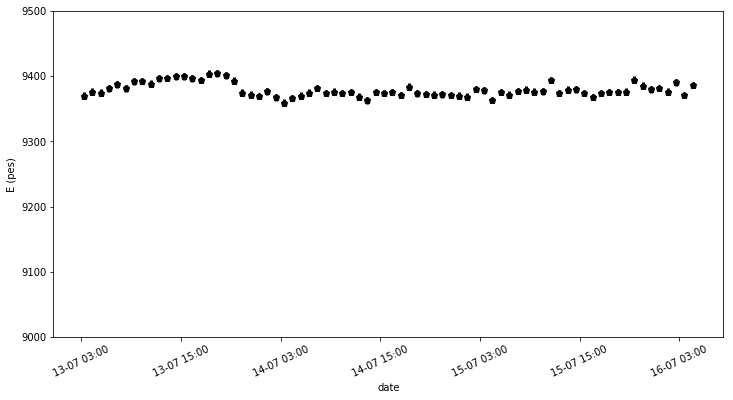

In [177]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9000, 9500),  
                    figsize=(12,6))

#### After

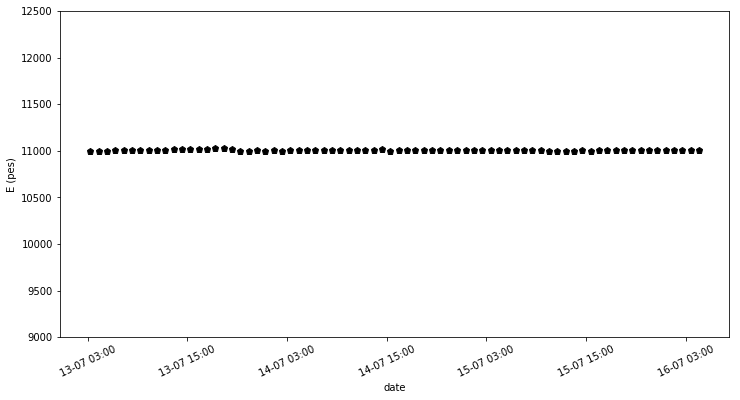

In [178]:
energy_time_profile(kre.T, kre.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9000, 12500),  
                    figsize=(12,6))

### Radial dependence

#### Before

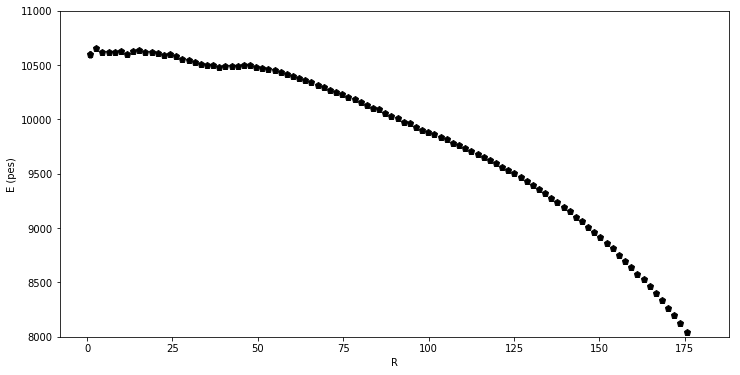

In [179]:
energy_X_profile(dst.R, dst.S2e, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

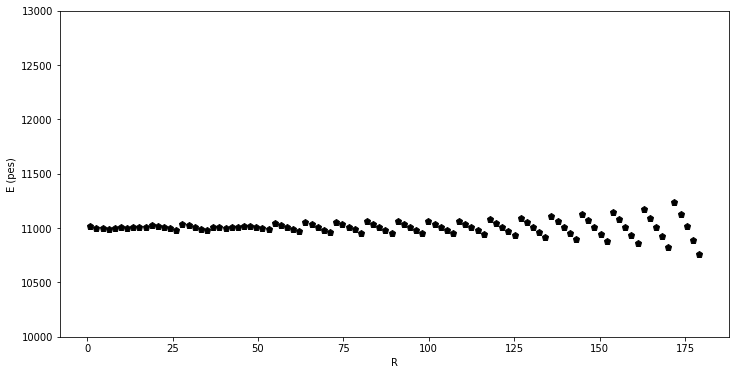

In [180]:
energy_X_profile(kre.R, kre.E, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 13000),  
                 figsize=(12,6))

### Phi distribution

#### Before

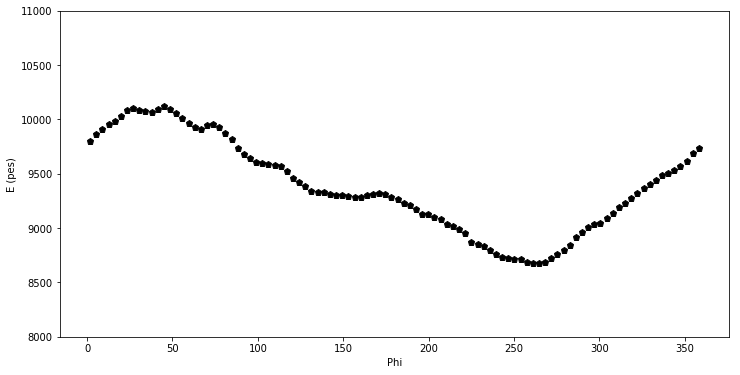

In [181]:
energy_X_profile(phirad_to_deg(dst.Phi), dst.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

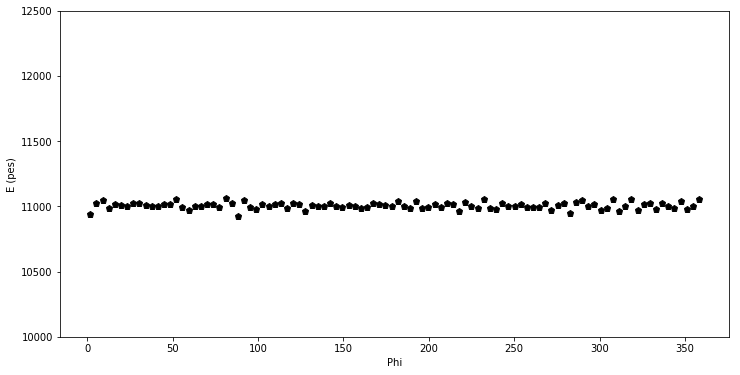

In [182]:
energy_X_profile(phirad_to_deg(kre.Phi), kre.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(10000, 12500),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

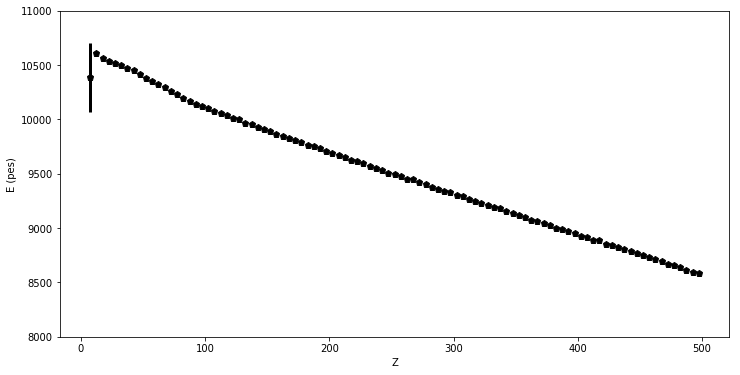

In [183]:
energy_X_profile(dst.Z, dst.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Lifetime corrected

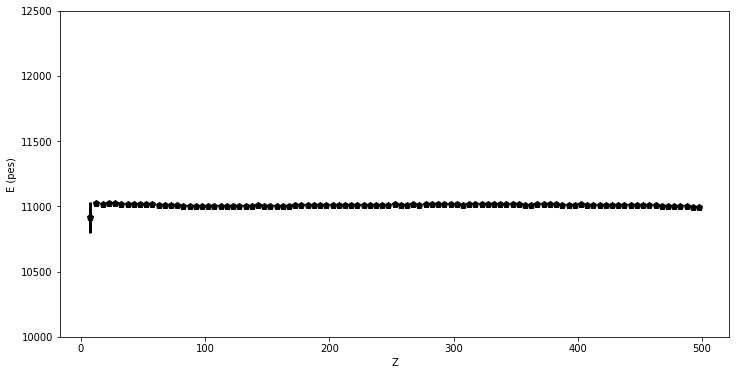

In [184]:
energy_X_profile(kre.Z, kre.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(10000, 12500),   
                 figsize=(12,6))

## Further geometrical correction is needed. This is done defining a fine-grained map for energy

In [244]:
R, PHI = rphi_sector_alpha_map(rmin  =  10,
                               rmax  = 180,
                               alpha =  0.7,
                               sphi  = 3)

rmin = 10, rmax = 180, alpha =0.7, nSectors = 97


In [245]:
R, PHI = rphi_sector_map(nSectors=50, rmax=180, sphi=3)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [246]:
nSectors = len(R.keys())

In [247]:
W = define_rphi_sectors(R, PHI, verbose=False)

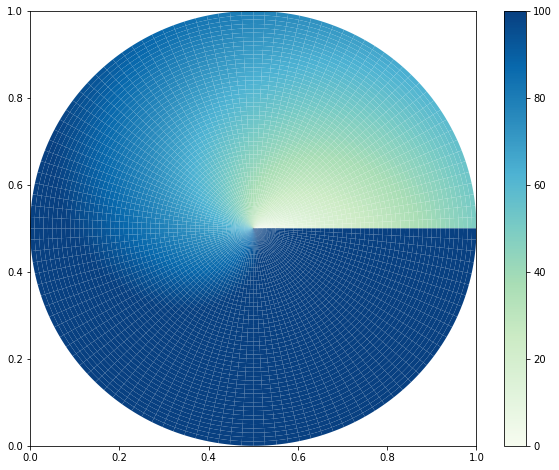

In [248]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(nSectors))

In [249]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, E, W, verbose = True)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 calling selection_mask
 sector = 0
 sector = 1
 sector = 2
 sector = 3
 sector = 4
 sector = 5
 sector = 6
 sector = 7
 sector = 8
 sector = 9
 sector = 10
 sector = 11
 sector = 12
 sector = 13
 sector = 14
 sector = 15
 sector = 16
 sector = 17
 sector = 18
 sector = 19
 sector = 20
 sector = 21
 sector = 22
 sector = 23
 sector = 24
 sector = 25
 sector = 26
 sector = 27
 sector = 28
 sector = 29
 sector = 30
 sector = 31
 sector = 32
 sector = 33
 sector = 34
 sector = 35
 sector = 36
 sector = 37
 sector = 38
 sector = 39
 sector = 40
 sector = 41
 sector = 42
 sector = 43
 sector = 44
 sector = 45
 sector = 46
 sector = 47
 sector = 48
 sector = 49
 selection_mask computed, filling RGES
 defining kr_event for sector 0
 defining kr_event for sector 1
 defining kr_event for sector 2
 defining kr_event for sector 3
 defining kr_event for sector 4
 defining kr_event for sector 5
 defining kr_event for sector 6
 defining kr_event for sector 7
 defining kr_event for sector 8
 defining

In [250]:
nMap = event_map(KRES)

In [251]:
nS = events_sector(nMap)

In [252]:
nS

array([  12.19166667,   35.88333333,   58.86666667,   82.55      ,
        105.85833333,  129.60833333,  152.61666667,  171.65      ,
        193.20833333,  212.61666667,  235.74166667,  261.40833333,
        288.98333333,  314.125     ,  334.70833333,  353.46666667,
        379.35833333,  402.55833333,  423.56666667,  450.525     ,
        474.675     ,  503.21666667,  525.71666667,  543.075     ,
        569.99166667,  590.56666667,  614.03333333,  639.7       ,
        667.83333333,  686.89166667,  713.59166667,  739.24166667,
        766.66666667,  788.58333333,  817.24166667,  835.26666667,
        867.81666667,  886.04166667,  912.325     ,  931.74166667,
        955.76666667,  975.31666667,  998.575     , 1019.65833333,
       1047.175     , 1068.25833333, 1084.36666667, 1105.88333333,
       1117.83333333, 1126.36666667])

In [253]:
eM = energy_map(KRES)

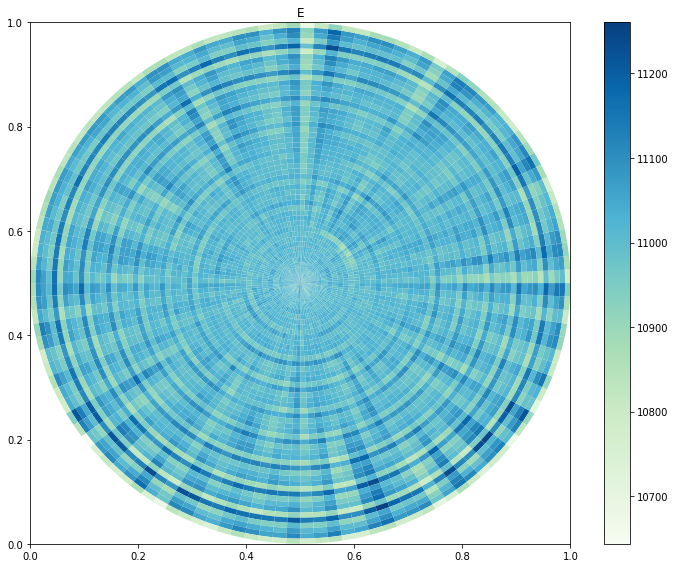

In [254]:
draw_map(W, eM, 
         alims  = None,
         title = 'E',
         cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
         alpha   = 1.0,  
         figsize=(10,8))

In [255]:
write_energy_map(eM, filename=fn.emap_file_name)


In [256]:
eMap = read_energy_map(filename=fn.emap_file_name)

In [257]:
mu = (eMap.mean()).mean()
mu

11008.860776803289

In [311]:
ns = 50 # number of radial sectors used to compute map
nw = 120 # number of phi sectors used to compute map

fr = RMAX / ns
fphi = 360 / nw
print(f'fr = {fr}, fphi = {fphi}')

fr = 3.6, fphi = 3.0


In [312]:
t0 = time.time()
Ec = e0_correction(kre.E, 
                  kre.R, 
                  kre.Phi, 
                  CE = eMap / mu,  # normalize to mean
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 28.986698865890503


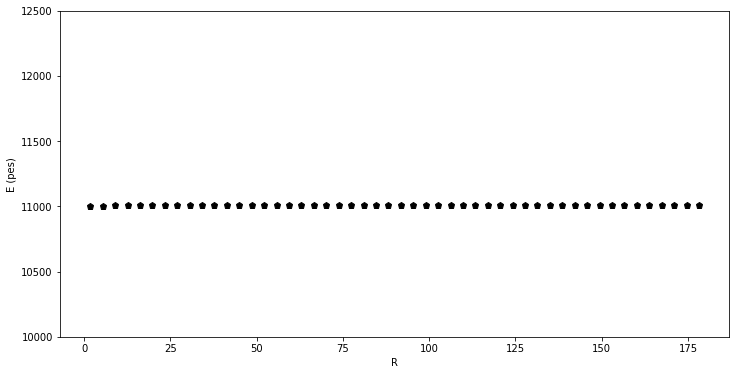

In [261]:
energy_X_profile(kre.R, Ec, xnbins = 50, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 12500),  
                 figsize=(12,6))

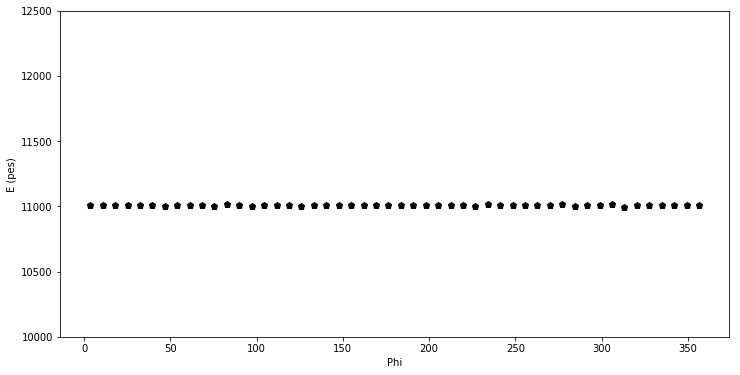

In [262]:
energy_X_profile(phirad_to_deg(kre.Phi), Ec, xnbins = 50, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(10000, 12500),  
                 figsize=(12,6))

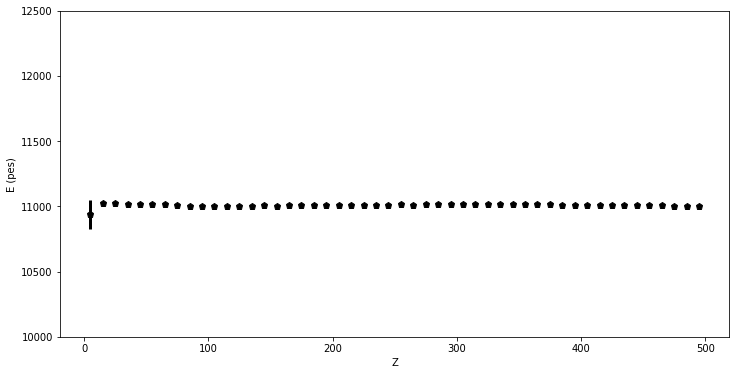

In [263]:
energy_X_profile(kre.Z, Ec, xnbins = 50, xrange=(0,500), xlabel = 'Z',
                 erange=(10000, 12500),   
                 figsize=(12,6))

### R and Phi distributions fixed, Z showing residual effects

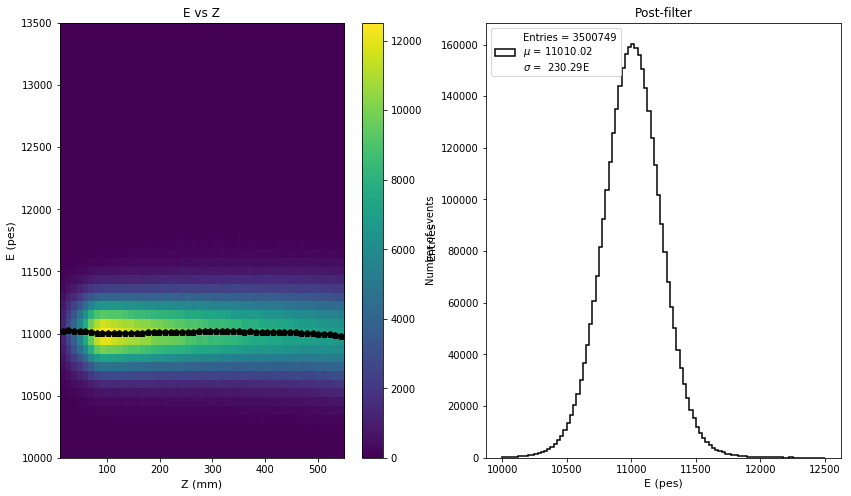

In [286]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kre.Z, Ec, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ec,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 11009.230557419563 +-0.12039335162680312 
 E sigma   = 222.3142435980898 +-0.09207762469000746 
 chi2    = 14.579707259163449 
 sigma E/E (FWHM)     (%) =4.745458547086369
 sigma E/E (FWHM) Qbb (%) =0.6128852551059196 


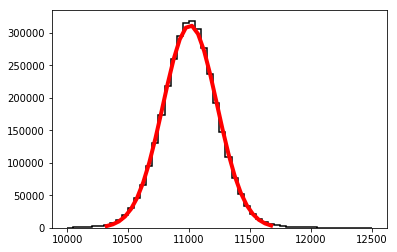

In [287]:
fc = fit_energy(Ec, nbins=50, range=(10000, 12500))
plot_fit_energy(fc)
print_fit_energy(fc)

### Time correction

(10000, 12500)

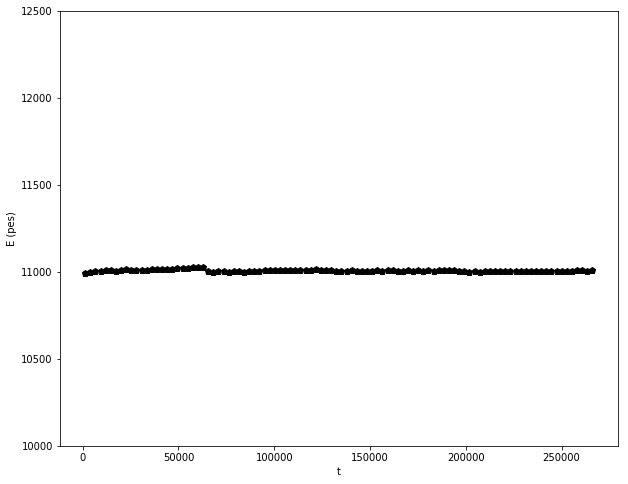

In [313]:
T   =(kre.T - kre.T.min()) 
t, e, eu = fitf.profileX(T, Ec, 100)
erange =(10000, 12500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [314]:
e_mu    = np.nanmean(Ec)
print(e_mu)
e_std   = np.nanstd (Ec)
print(e_std)

11008.375099700103
230.63962244179257


In [315]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = Ec * ET_correction(T).value

(10000, 12500)

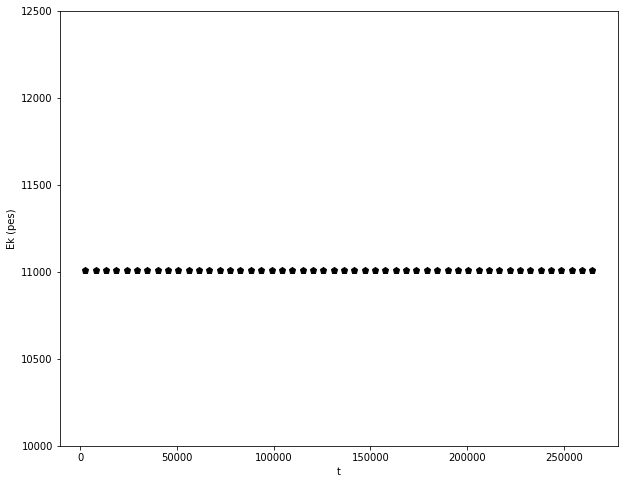

In [316]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

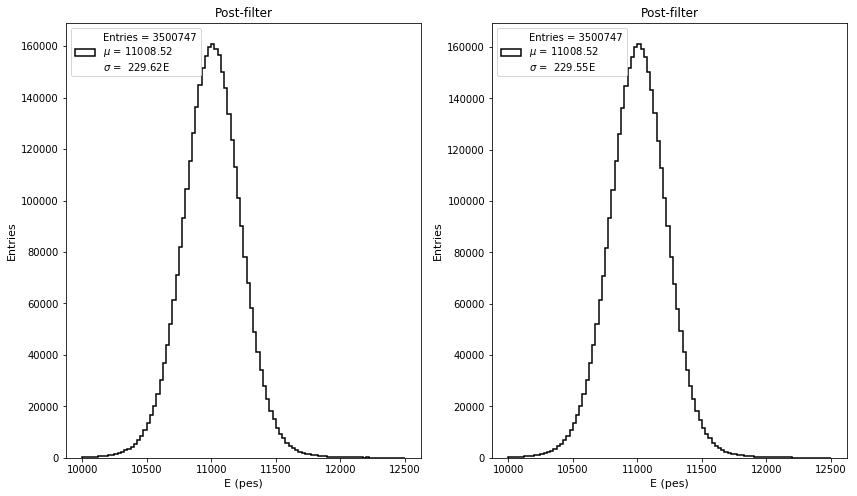

In [317]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(Ec,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 11007.75232399522 +-0.11997340247510575 
 E sigma   = 221.60638053880504 +-0.09168355723423541 
 chi2    = 14.674974158731425 
 sigma E/E (FWHM)     (%) =4.730983936938532
 sigma E/E (FWHM) Qbb (%) =0.6110158308880087 


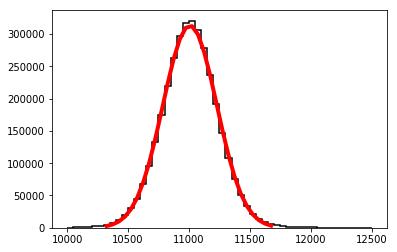

In [318]:
fc = fit_energy(Ek, nbins=50, range=(10000, 12500))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

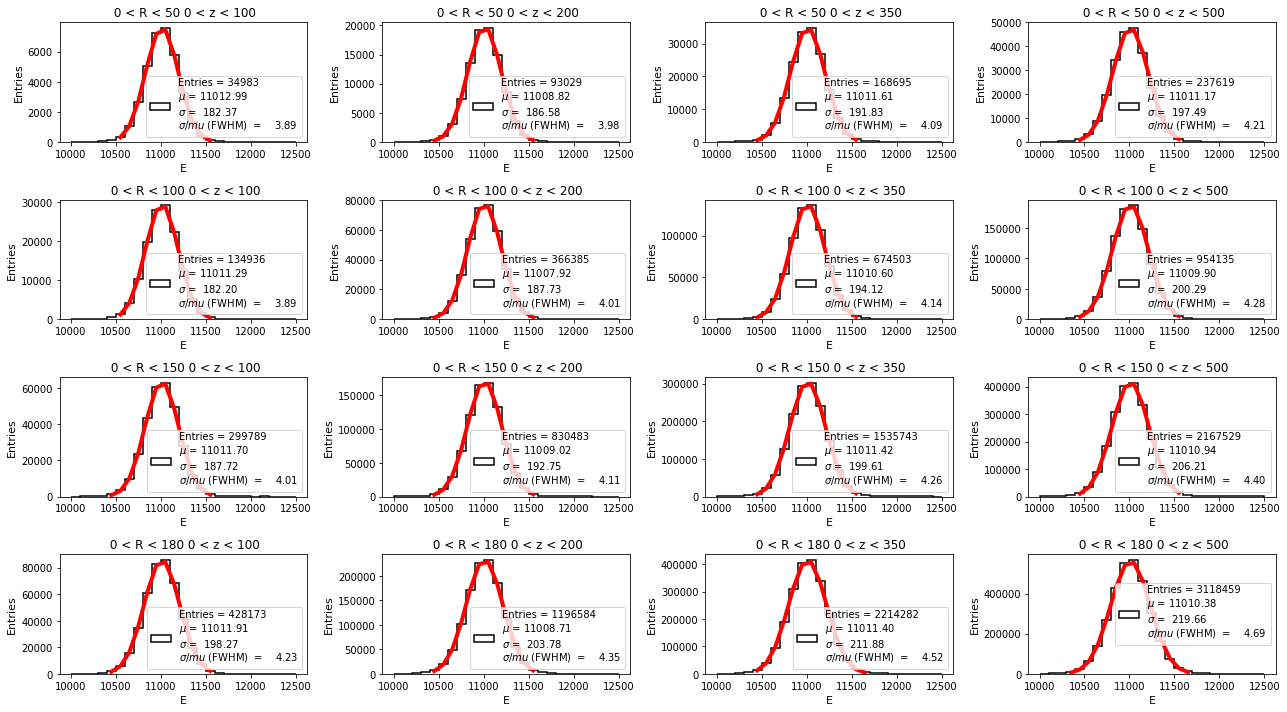

In [319]:
Ri = (50,100,150,180)
Zi = range(50,600,50)

Ri = (50,100,150,180)
Zi = (100,200,350,500)



FC, FCE = resolution_r_z(Ri, Zi, kre.R, kre.Z, Ek,
                    enbins = 25,
                    erange = (10e+3, 12500),
                    ixy = (4,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))                                

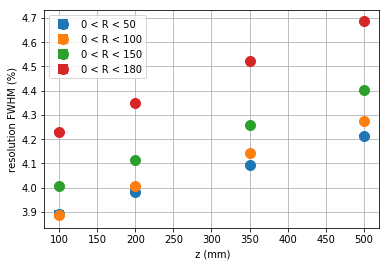

In [320]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

In [328]:
Ri = (50,100,150,180)
Zi = range(100,600,50)

FC, FCE = resolution_r_z(Ri, Zi, kre.R, kre.Z, Ek,
                    enbins = 25,
                    erange = (10e+3, 12500),
                    ixy = (4,4),
                    fdraw  = False,
                    fprint = False,
                    figsize = (18,10))                                

<Figure size 432x288 with 0 Axes>

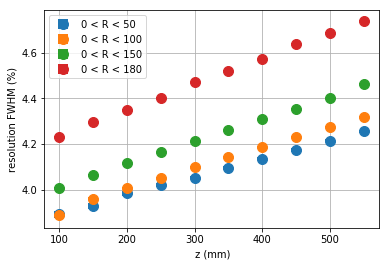

In [329]:
plot_resolution_r_z(Ri, Zi, FC, FCE)
